# Graph Neural Networks for Solving Combinatorial Optimization Problems

<a href="https://colab.research.google.com/github/IvanIsCoding/GNN-for-Combinatorial-Optimization/blob/main/00_GNN_Definition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-6fb616c8-9603-5548-2b8c-524d04dfc3cf)


During this notebook we will be using:
* [JAX](https://github.com/google/jax): a numerical computation library for Python, supports automatic differentiation and many other cool things
* [Flax](https://github.com/google/flax): a machine learning library for Python built on top of JAX; Flax is very fexible and provides all the tools we need to implement the paper
* [PyQUBO](https://arxiv.org/abs/2103.01708): a library for building quadratic unconstrained binary optimization (QUBO) models; this paper is all about QUBOs, and PyQUBO lets us write them in a straightforward way
* [Wntr](https://wntr.readthedocs.io/en/latest/overview.html): a library for reading epanet files i.e. water distribution networks
* [Pandapower](https://pandapower.readthedocs.io/en/v1.6.1/about.htmll): a library for reading electricity grid networks used in MATPOWER


In [ ]:
!pip install -q flax pyqubo wntr==0.5 pandapower

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 116.5 MB/s eta 0:00:00


In [ ]:
# | export
import jax
import jax.numpy as jnp
import numpy as np
import networkx as nx  # for making graphs
import optax  # for optimizing GNN with Adam

from flax import linen as nn  # for defining the GNN
from flax.training import train_state  # utility for training
from pyqubo import Array  # for defining the QUBO
from tqdm.notebook import trange, tqdm  # visualizing notebook progress
from networkx.algorithms.approximation import min_weighted_vertex_cover

## QUBO Background

Now that we have installed and imported the libraries we need, let's dicuss QUBO formulations. 

QUBOs are a specific way to encode optimization problems. You have binary variables $x_{i} \in \{0, 1\}$ and write a Hamiltonian:

$$
H = \sum_{i=1}^{N} \sum_{j=i+1}^{N} b_{i,j}x_{i}x_{j} \sum_{i=1}^{N} a_{i} x_{i} + c
$$

Then, you give your Hamiltonian to a QUBO solver and (hopefully) the solver outputs a solution that minimizes $H$. Generally, the output from the solver is decoded and mapped back to a combinatorial optimization problem that is useful in the real-world. I recommend reading [Ising formulations of many NP problems](https://www.frontiersin.org/articles/10.3389/fphy.2014.00005/full) by Lucas if you are interested more in the topic. Many, many problems can be encoded as QUBOs.

There is also another convenient way of writing QUBO problems using matrices. Let $Q$ be the matrix describe the QUBO coefficients, then:

$$
H = x^\intercal Q x
$$

They are equivalent, but for this specific case the matrix version is the one used in the paper. This makes sense given that the authors also want to reach the Deep Learning community that is familiar with linear algebra.

In [ ]:
# | export
def create_max_cut_model(graph):
    N = graph.number_of_nodes()
    X = Array.create("X", shape=(N,), vartype="BINARY")

    hamiltonian = 0
    for u, v in graph.edges:
        hamiltonian -= (X[u] - X[v]) ** 2

    return hamiltonian.compile()


def create_mis_model(graph, penalty=1):
    N = graph.number_of_nodes()
    X = Array.create("X", shape=(N,), vartype="BINARY")

    hamiltonian = -sum(X)
    for u, v in graph.edges:
        hamiltonian += penalty * (X[u] * X[v])

    return hamiltonian.compile()

def create_mvc_model(graph, penalty=2):
    N = graph.number_of_nodes()
    X = Array.create("X", shape=(N,), vartype="BINARY")

    hamiltonian = sum(X)
    for u, v, w in graph.edges:
        hamiltonian += penalty * (1 - X[int(u)])*(1 - X[int(v)])
    for u in graph.nodes:
        hamiltonian += X[int(u)]
    return hamiltonian.compile() 


def create_Q_matrix(graph, label=""):
    if label == "max_c":
        model = create_max_cut_model(graph)
    elif label == "mis":
        model = create_mis_model(graph)
    else:
        model = create_mvc_model(graph)

    N = graph.number_of_nodes()
    extract_val = lambda x: int(x[2:-1])
    Q_matrix = np.zeros((N, N))

    qubo_dict, _ = model.to_qubo()
    print(qubo_dict)

    for (a, b), quv in qubo_dict.items():
        u = min(extract_val(a), extract_val(b))
        v = max(extract_val(a), extract_val(b))
        Q_matrix[u, v] = quv

    return jnp.array(Q_matrix)

The two functions below implement a cost inspired by the hamiltonian using the QUBO matrix discussed earlier:

$$
H = x^\intercal Q x
$$

Notice that in the paper, as we will discussed later, we transition to a relaxed version of the Hamiltonian cost:

$$
\mathcal{L}_{QUBO} = p_{\Theta}^\intercal Q p_{\Theta} 
$$

Where $p_{\Theta}$ is a vector of probabilities. Instead of assigning 0 or 1 to the variables, the authors chose a continuous version which makes sense for training the GNN.

In [ ]:
# | export
def qubo_approx_cost(probs, Q):
    cost = jnp.sum(jnp.matmul(jnp.matmul(jnp.transpose(probs), Q), probs))
    return cost

In [ ]:
# | export
def compute_metrics(*, probs, q_matrix):
    energy = qubo_approx_cost(probs=probs, Q=q_matrix)
    metrics = {
        "energy": energy,
    }
    return metrics

## The Graph Convolution

We enter now the Neural Network section of the paper where we defined the architecture of the Graph Neural Network.

The core idea is using message passing. Each vertex $i$ in the graph contains a node feature vector $\textbf{x}_{i}$. The Graph Convolution learns to aggregate the messages of the vertex and its neighbours using $W_{1}$ and $W_{2}$:

$$
\textbf{x}_{i}^{\prime} = W_{1} \textbf{x}_{i} + W_{2} \sum_{j \in \mathcal{N}_{i}} e_{j, i} \textbf{x}_{j}
$$


We implement the Graph Convolution below using Flax + JAX. To calcualte $\sum_{j \in \mathcal{N}_{i}} e_{j, i} x_{j}$, we use the adjacency matrix of the graph. Notice that our implementation is focused on smaller graphs, hence we did not use sparse matrices which would allow our code to scale to graphs with millions of vertices.

In [ ]:
# | export
class GraphConvLayer(nn.Module):
    c_out: int  # Output feature size

    @nn.compact
    def __call__(self, node_feats, adj_matrix):
        node_feats_w1 = nn.Dense(features=self.c_out, use_bias=False)(node_feats)
        node_feats_w2 = jax.lax.batch_matmul(adj_matrix, node_feats)
        node_feats_w2 = nn.Dense(features=self.c_out)(node_feats_w2)
        return node_feats_w1 + node_feats_w2

## Unsupervised Learning and the Graph Neural Network 


After explaining the Graph Convolution layer, we can talk about the GNN architecture and its goals.

The idea proposed is to apply unsupervised learning to learn the node labels of the optimal solution just by using $\mathcal{L}_{QUBO}$. Let's say that the optimal solution is:

$$
x^\intercal  = \begin{bmatrix} 1, 0, 1, 0, 1 \end{bmatrix}
$$

Then, our neural network is trying to predict probabilities that the label is 0 or 1. So $p_{\Theta}$ would look something like this:

$$
p_{\Theta}^\intercal  = \begin{bmatrix} 0.9, 0.05, 0.87, 0.13, 0.99 \end{bmatrix}
$$

$\mathcal{L}_{QUBO}$ would give us an approximate cost of the QUBO (as if $p_{\Theta}$ were a superposition of many $x$). So overall, this is a pretty clever idea.

To find $p_{\Theta}$, they propose the following architecture for the GNN:
* Initialize the feature vectors $\textbf{x}_{i}$ for each vertex at random
* $k$ layers consisting of:
    * Applying the Graph Convolution
    * Applying an activation function which in the case is ReLU
    * Applying Dropout regularization to reduce overfitting

On the last of the $k$ layers, no ReLU or Regularization is applied. Instead, a Softmax to predict the probabilities takes place.

We can use $k = 2$ or $k = 3$ layers depending upon the problem size. For our Flax implementation. we use $k = 2$.

In [ ]:
# | export
# Uncomment if you need 3rd GCN Layer
class CombGNN(nn.Module):
    hidden_size: int
    num_classes: int
    dropout_frac: float

    @nn.compact
    def __call__(self, node_feats, adj_matrix, train=False):
        # First convolution
        h = GraphConvLayer(c_out=self.hidden_size)(
            node_feats=node_feats, adj_matrix=adj_matrix
        )
        h = nn.relu(h)
        h = nn.Dropout(rate=self.dropout_frac, deterministic=not train)(h)
        # Second convolution
        # h = GraphConvLayer(c_out=self.hidden_size//2)(
        #     node_feats=h, adj_matrix=adj_matrix
        # )
        # h = nn.relu(h)
        # h = nn.Dropout(rate=self.dropout_frac, deterministic=not train)(h)
        # Third convolution
        h = GraphConvLayer(c_out=self.num_classes)(node_feats=h, adj_matrix=adj_matrix)
        probs = nn.sigmoid(h)

        return probs

## Training neural networks with Flax

Now that we defined our architecture, it is time to write code to train the neural network!

Flax provides a TrainState dataclass that is very convenient to keep track of the paramters. Hence the code below does:
* Initiates the parameters for GNNComb using random values
* Assigns the Adam optimizer with the given learning rate (using optax, the optimizer for JAX)
* Returns a TrainState keeping track of our net, the current parameters, and all other hyperparameters we chose

In [ ]:
# | export
def create_train_state(
    n_vertices, embedding_size, hidden_size, rng, learning_rate, dropout_frac=0.0
):
    gnn = CombGNN(hidden_size=hidden_size, num_classes=1, dropout_frac=dropout_frac)
    dropout_rng = jax.random.PRNGKey(0)
    params = gnn.init(
        rngs={"params": rng, "dropout": dropout_rng},
        node_feats=jnp.ones([n_vertices, embedding_size]),
        adj_matrix=jnp.ones([n_vertices, n_vertices]),
        train=True,
    )["params"]
    tx = optax.adam(learning_rate)
    return train_state.TrainState.create(apply_fn=gnn.apply, params=params, tx=tx)

After we have our convenient TrainState class, we are going to perform training steps on them. One of the true magics of JAX is it just-in-time compilation. We apply the `@jax.jit` decorator to compile the code and make things super fast!

To train the neural network, we:
* Evaluate the GNN using the current parameters
* Calcualte the cost $\mathcal{L}_{QUBO}$
* Calcualte the gradients using JAX, which does all the backpropagation for us
* Let the optimizer handle the gradients and update the parameters

In [ ]:
# | export
@jax.jit
def train_step(state, node_embeddings, adj_matrix, q_matrix, dropout_rng):
    """Train for a single step."""

    def cost_fn(params):
        probs = state.apply_fn(
            {"params": params},
            node_embeddings,
            adj_matrix,
            rngs={"dropout": dropout_rng},
            train=True,
        )
        cost = qubo_approx_cost(probs=probs, Q=q_matrix)
        return cost, probs

    grad_fn = jax.grad(cost_fn, has_aux=True)
    grads, probs = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    metrics = compute_metrics(probs=probs, q_matrix=q_matrix)
    return state, metrics

Last but not least on our training steps, is an utility method to recover the classifications. We are not interested in probabilities at the end. We want zeroes or ones!

In [ ]:
# | export
def get_classification(apply_fn, params, node_embeddings, adj_matrix):
    pred_probs = apply_fn({"params": params}, node_embeddings, adj_matrix)
    classification = jnp.where(pred_probs >= 0.5, 1, 0)
    return np.ravel(classification)

# Max-Cut On Example Graph

After all this introduction, it is time to check if our implementation works, right? We will start with the Max-Cut case.

We check our implementation against the small example present in the paper. So let's first define and visualize our graph.

In [ ]:
edgelist = [(0, 1), (0,2), (1,3), (2,3), (2,4), (3,4)]
G = nx.from_edgelist(edgelist)
G = G.to_undirected()

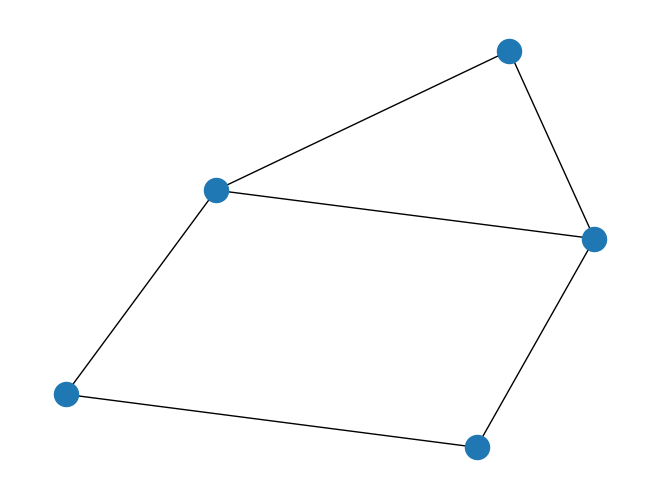

In [ ]:
nx.draw(G, pos=nx.spring_layout(G), label = True)

Alright, our graph looks ready. Time to calculate two very important matrices for our training steps: the adjacency matrix $A$ and the QUBO matrix $Q$. $A$ is used in the graph convolutions and $Q$ is used for the cost. We take a peek at $A$ and $Q$ to check if they are correct

In [ ]:
A = jnp.array(nx.to_numpy_array(G), label="max_c")

In [ ]:
A

Array([[0., 1., 1., 0., 0.],
       [1., 0., 0., 1., 0.],
       [1., 0., 0., 1., 1.],
       [0., 1., 1., 0., 1.],
       [0., 0., 1., 1., 0.]], dtype=float32)

In [ ]:
A

Array([[0., 1., 1., 0., 0.],
       [1., 0., 0., 1., 0.],
       [1., 0., 0., 1., 1.],
       [0., 1., 1., 0., 1.],
       [0., 0., 1., 1., 0.]], dtype=float32)

In [ ]:
Q = create_Q_matrix(G)

{('X[4]', 'X[4]'): -2.0, ('X[3]', 'X[4]'): 2.0, ('X[3]', 'X[3]'): -3.0, ('X[1]', 'X[0]'): 2.0, ('X[4]', 'X[2]'): 2.0, ('X[2]', 'X[0]'): 2.0, ('X[3]', 'X[2]'): 2.0, ('X[3]', 'X[1]'): 2.0, ('X[0]', 'X[0]'): -2.0, ('X[1]', 'X[1]'): -2.0, ('X[2]', 'X[2]'): -3.0}


In [ ]:
Q

Array([[-2.,  2.,  2.,  0.,  0.],
       [ 0., -2.,  0.,  2.,  0.],
       [ 0.,  0., -3.,  2.,  2.],
       [ 0.,  0.,  0., -3.,  2.],
       [ 0.,  0.,  0.,  0., -2.]], dtype=float32)

The matrices look right. Time to train the neural network! The code:
* Creates the random number keys we need for initializing the network, embeddings, and training
* Defines our learning rate, size of node featurs, and size of the hidden features
* Trains the network for 500 epochs

note: JAX has a very particular way of working with random numbers; if you are new to JAX, pay attention to that

In [ ]:
rng = jax.random.PRNGKey(2023)
rng, init_rng = jax.random.split(rng)
rng, embed_rng = jax.random.split(rng)

In [ ]:
learning_rate = 0.005

In [ ]:
embedding_d0 = 5
embedding_d1 = embedding_d0 // 2

In [ ]:
state = create_train_state(
    G.number_of_nodes(), embedding_d0, embedding_d1, init_rng, learning_rate
)

In [ ]:
node_embeddings = jax.random.uniform(embed_rng, [G.number_of_nodes(), embedding_d0])

In [ ]:
node_embeddings

Array([[0.90081596, 0.38583064, 0.02542734, 0.7263125 , 0.77239466],
       [0.13210392, 0.2291317 , 0.15860796, 0.39851677, 0.9010197 ],
       [0.5372865 , 0.6941434 , 0.948866  , 0.5196214 , 0.97492456],
       [0.13318086, 0.49488008, 0.6443068 , 0.95046246, 0.5960568 ],
       [0.19223976, 0.44076335, 0.9235079 , 0.26473606, 0.49318063]],      dtype=float32)

In [ ]:
num_epochs = 500

In [ ]:
for epoch in trange(1, num_epochs + 1):
    rng, dropout_rng = jax.random.split(rng)
    state, metrics = train_step(
        state=state,
        node_embeddings=node_embeddings,
        adj_matrix=A,
        q_matrix=Q,
        dropout_rng=dropout_rng,
    )

    if epoch % 25 == 0:
        print("train epoch: %d, cost: %.2f" % (epoch, metrics["energy"]))

  0%|          | 0/500 [00:00<?, ?it/s]

train epoch: 25, cost: -0.29
train epoch: 50, cost: -0.77
train epoch: 75, cost: -1.34
train epoch: 100, cost: -1.92
train epoch: 125, cost: -2.56
train epoch: 150, cost: -3.13
train epoch: 175, cost: -3.57
train epoch: 200, cost: -3.86
train epoch: 225, cost: -4.05
train epoch: 250, cost: -4.17
train epoch: 275, cost: -4.25
train epoch: 300, cost: -4.31
train epoch: 325, cost: -4.37
train epoch: 350, cost: -4.43
train epoch: 375, cost: -4.50
train epoch: 400, cost: -4.57
train epoch: 425, cost: -4.63
train epoch: 450, cost: -4.69
train epoch: 475, cost: -4.75
train epoch: 500, cost: -4.79


After finding the optimal parameters, let's examine the solution the network found:

In [ ]:
state.apply_fn({"params": state.params}, node_embeddings, A, train=False)

Array([[0.01253788],
       [0.9991603 ],
       [0.99846715],
       [0.00289477],
       [0.92819667]], dtype=float32)

Probabilities are not very useful, so let's convert them to zeroes and ones and visualize:

In [ ]:
classification = get_classification(state.apply_fn, state.params, node_embeddings, A)

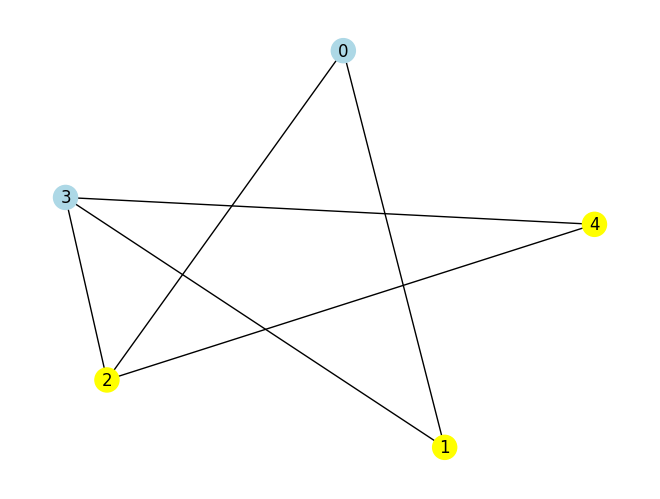

In [ ]:
nx.draw(
    G,
    pos=nx.spring_layout(G, seed=2023),
    node_color=["yellow" if c else "lightblue" for c in classification],
    with_labels=True,
)

The GNN found the optimal solution to the problem! The Max-Cut of the graph is 5 because of the edges $\{ (0, 1), (0, 3), (2, 1), (2, 3), (4, 1)\}$. Hence the code worked!

# Maximum Independet Set on Example Graph

We also need to check that our MIS implementation works. Most of the training details are the same. The major difference is on the $Q$ matrix below that looks quite different.

In [ ]:
A

Array([[0., 1., 1., 0., 0.],
       [1., 0., 0., 1., 0.],
       [1., 0., 0., 1., 1.],
       [0., 1., 1., 0., 1.],
       [0., 0., 1., 1., 0.]], dtype=float32)

In [ ]:
A = jnp.array(nx.to_numpy_array(G))
Q = create_Q_matrix(G, label="mis")

{('X[4]', 'X[4]'): -15.0, ('X[3]', 'X[4]'): 8.0, ('X[3]', 'X[3]'): -23.0, ('X[1]', 'X[0]'): 8.0, ('X[4]', 'X[2]'): 8.0, ('X[2]', 'X[0]'): 8.0, ('X[3]', 'X[2]'): 8.0, ('X[3]', 'X[1]'): 8.0, ('X[0]', 'X[0]'): -15.0, ('X[1]', 'X[1]'): -15.0, ('X[2]', 'X[2]'): -23.0}


In [ ]:
Q

Array([[-15.,   8.,   8.,   0.,   0.],
       [  0., -15.,   0.,   8.,   0.],
       [  0.,   0., -23.,   8.,   8.],
       [  0.,   0.,   0., -23.,   8.],
       [  0.,   0.,   0.,   0., -15.]], dtype=float32)

In [ ]:
def makeSymmetric(mat):
    N = mat.shape[0]
    mat = np.array(mat)
    # Loop to traverse lower triangular
    # elements of the given matrix
    for i in range(0, N):
        for j in range(0, N):
            if (j < i):
                mat[i][j] = mat[j][i] = (mat[i][j] +
                                         mat[j][i]) // 2
    return jnp.array(mat)

In [ ]:
Q = makeSymmetric(Q)

In [ ]:
Q

Array([[-15.,   4.,   4.,   0.,   0.],
       [  4., -15.,   0.,   4.,   0.],
       [  4.,   0., -23.,   4.,   4.],
       [  0.,   4.,   4., -23.,   4.],
       [  0.,   0.,   4.,   4., -15.]], dtype=float32)

In [ ]:
rng = jax.random.PRNGKey(2023)  # yeah I know
rng, init_rng = jax.random.split(rng)
rng, embed_rng = jax.random.split(rng)

In [ ]:
learning_rate = 0.01

In [ ]:
embedding_d0 = 5
embedding_d1 = embedding_d0 // 2

In [ ]:
state = create_train_state(
    G.number_of_nodes(), embedding_d0, embedding_d1, init_rng, learning_rate
)

In [ ]:
node_embeddings = jax.random.uniform(embed_rng, [G.number_of_nodes(), embedding_d0])

In [ ]:
num_epochs = 500

In [ ]:
for epoch in trange(1, num_epochs + 1):
    state, metrics = train_step(
        state=state,
        node_embeddings=node_embeddings,
        adj_matrix=A,
        q_matrix=Q,
        dropout_rng=dropout_rng,
    )

    if epoch % 25 == 0:
        print("train epoch: %d, cost: %.2f" % (epoch, metrics["energy"]))

  0%|          | 0/500 [00:00<?, ?it/s]

train epoch: 25, cost: -41.07
train epoch: 50, cost: -42.87
train epoch: 75, cost: -42.93
train epoch: 100, cost: -42.95
train epoch: 125, cost: -42.96
train epoch: 150, cost: -42.97
train epoch: 175, cost: -42.97
train epoch: 200, cost: -42.98
train epoch: 225, cost: -42.98
train epoch: 250, cost: -42.98
train epoch: 275, cost: -42.98
train epoch: 300, cost: -42.99
train epoch: 325, cost: -42.99
train epoch: 350, cost: -42.99
train epoch: 375, cost: -42.99
train epoch: 400, cost: -42.99
train epoch: 425, cost: -42.99
train epoch: 450, cost: -42.99
train epoch: 475, cost: -42.99
train epoch: 500, cost: -42.99


In [ ]:
classification = get_classification(state.apply_fn, state.params, node_embeddings, A)

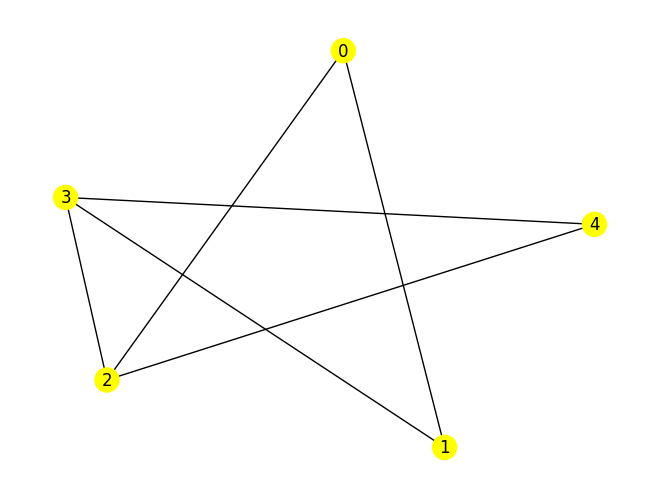

In [ ]:
nx.draw(
    G,
    pos=nx.spring_layout(G, seed=2023),
    node_color=["yellow" if c else "lightblue" for c in classification],
    with_labels=True,
)

The GNN found again the optimal solution! The MIS has size 2 and the GNN found the solution with vertices 0 and 2.

# Max-Cut on a Larger Graph

In general, the GNN will not necessarily find the optimal solution but an approximate solution. Despite that, approximate solutions can be useful as solving the exact problem is hard for larger graphs.

We test our code against a random graph with 100 vertices. This should be a tougher challenge for the GNN than the previous two cases we analyzed earlier.

In [ ]:
G = nx.convert_node_labels_to_integers(
    nx.fast_gnp_random_graph(n=100, p=0.05, seed=2023)
)
A = jnp.array(nx.to_numpy_array(G))
Q = create_Q_matrix(G, label="max_c")
Q = makeSymmetric(Q)

In [ ]:
Q

Array([[-4.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., -6.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0., -4., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., -9.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0., -3.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0., -5.]], dtype=float32)

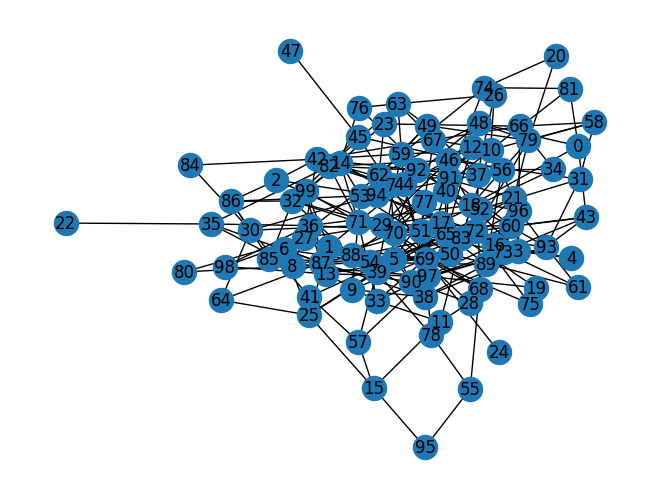

In [ ]:
nx.draw(G, pos=nx.spring_layout(G, seed=2023), with_labels=True)

In [ ]:
embedding_d0 = int(np.sqrt(G.number_of_nodes()))
embedding_d1 = embedding_d0 // 2

In [ ]:
learning_rate = 0.01

In [ ]:
rng = jax.random.PRNGKey(2023)
rng, init_rng = jax.random.split(rng)
rng, embed_rng = jax.random.split(rng)
state = create_train_state(
    G.number_of_nodes(),
    embedding_d0,
    embedding_d1,
    init_rng,
    learning_rate,
    dropout_frac=0.01,
)

In [ ]:
node_embeddings = jax.random.uniform(embed_rng, [G.number_of_nodes(), embedding_d0])

In [ ]:
num_epochs = 1000

In [ ]:
for epoch in trange(1, num_epochs + 1):
    rng, dropout_rng = jax.random.split(rng)
    state, metrics = train_step(
        state=state,
        node_embeddings=node_embeddings,
        adj_matrix=A,
        q_matrix=Q,
        dropout_rng=dropout_rng,
    )

    if epoch % 25 == 0:
        print("train epoch: %d, cost: %.2f" % (epoch, metrics["energy"]))

  0%|          | 0/1000 [00:00<?, ?it/s]

train epoch: 25, cost: -430.00
train epoch: 50, cost: -430.00
train epoch: 75, cost: -430.00
train epoch: 100, cost: -430.00
train epoch: 125, cost: -430.00
train epoch: 150, cost: -430.00
train epoch: 175, cost: -430.00
train epoch: 200, cost: -430.00
train epoch: 225, cost: -430.00
train epoch: 250, cost: -430.00
train epoch: 275, cost: -430.00
train epoch: 300, cost: -430.00
train epoch: 325, cost: -430.00
train epoch: 350, cost: -430.00
train epoch: 375, cost: -430.00
train epoch: 400, cost: -430.00
train epoch: 425, cost: -430.00
train epoch: 450, cost: -430.00
train epoch: 475, cost: -430.00
train epoch: 500, cost: -430.00
train epoch: 525, cost: -430.00
train epoch: 550, cost: -430.00
train epoch: 575, cost: -430.00
train epoch: 600, cost: -430.00
train epoch: 625, cost: -430.00
train epoch: 650, cost: -430.00
train epoch: 675, cost: -430.00
train epoch: 700, cost: -430.00
train epoch: 725, cost: -430.00
train epoch: 750, cost: -430.00
train epoch: 775, cost: -430.00
train epoch

In [ ]:
classification = get_classification(state.apply_fn, state.params, node_embeddings, A)

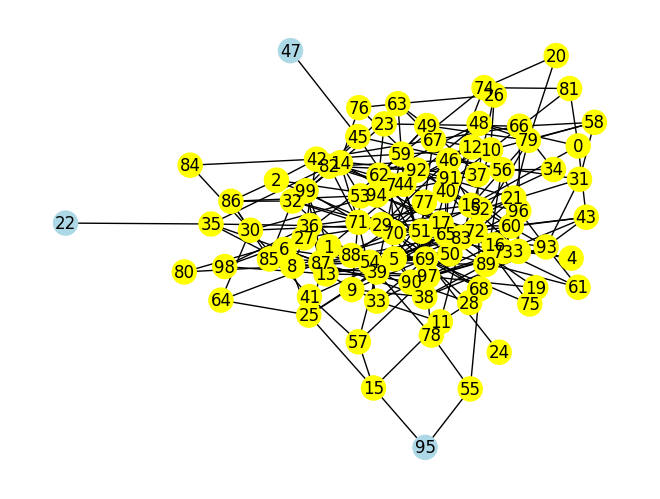

In [ ]:
nx.draw(
    G,
    pos=nx.spring_layout(G, seed=2023),
    node_color=["yellow" if c else "lightblue" for c in classification],
    with_labels=True,
)

Overall, our GNN seems to be working!

Now, let's jump onto the next notebook where we will compare the GNN against Simulated Annealing. The results will surprise you!

<a href="https://colab.research.google.com/github/IvanIsCoding/GNN-for-Combinatorial-Optimization/blob/main/01_GNN_vs_SA_for_Max_Cut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVC

We also need to check that our MVC implementation works. Most of the training details are the same. The major difference is on the  Q  matrix below that looks quite different.

In [ ]:
edgelist = [(0, 1), (0,2), (1,3), (2,3), (2,4), (3,4)]
G = nx.from_edgelist(edgelist)
G = G.to_undirected()

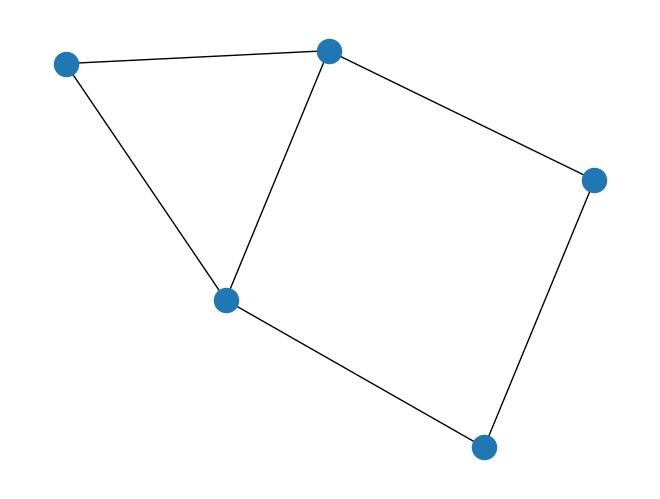

In [ ]:
nx.draw(G, pos=nx.spring_layout(G), label = True)

In [ ]:
# def create_mvc_model(graph, penalty=2):
#     N = graph.number_of_nodes()
#     X = Array.create("X", shape=(N,), vartype="BINARY")

#     hamiltonian = sum(X)
#     for u, v in graph.edges:
#         hamiltonian += penalty * (1 - X[int(u)])*(1 - X[int(v)])
#     for u in graph.nodes:
#         hamiltonian += X[int(u)]*5
#     return hamiltonian.compile() 

In [ ]:
G = nx.convert_node_labels_to_integers(
    nx.fast_gnp_random_graph(n=100, p=0.05, seed=2023)
)
A = jnp.array(nx.to_numpy_array(G))
Q = create_Q_matrix(G, label="mvc")
# Q = makeSymmetric(Q)

{('X[84]', 'X[42]'): 2.0, ('X[96]', 'X[96]'): -8.0, ('X[48]', 'X[44]'): 2.0, ('X[69]', 'X[1]'): 2.0, ('X[79]', 'X[18]'): 2.0, ('X[87]', 'X[5]'): 2.0, ('X[69]', 'X[40]'): 2.0, ('X[71]', 'X[71]'): -8.0, ('X[88]', 'X[77]'): 2.0, ('X[91]', 'X[5]'): 2.0, ('X[90]', 'X[73]'): 2.0, ('X[90]', 'X[3]'): 2.0, ('X[88]', 'X[32]'): 2.0, ('X[51]', 'X[4]'): 2.0, ('X[91]', 'X[67]'): 2.0, ('X[65]', 'X[16]'): 2.0, ('X[13]', 'X[1]'): 2.0, ('X[88]', 'X[38]'): 2.0, ('X[70]', 'X[68]'): 2.0, ('X[4]', 'X[3]'): 2.0, ('X[46]', 'X[46]'): -4.0, ('X[24]', 'X[24]'): 4.0, ('X[35]', 'X[8]'): 2.0, ('X[53]', 'X[49]'): 2.0, ('X[86]', 'X[85]'): 2.0, ('X[79]', 'X[72]'): 2.0, ('X[58]', 'X[31]'): 2.0, ('X[81]', 'X[0]'): 2.0, ('X[82]', 'X[35]'): 2.0, ('X[46]', 'X[31]'): 2.0, ('X[92]', 'X[82]'): 2.0, ('X[94]', 'X[2]'): 2.0, ('X[46]', 'X[12]'): 2.0, ('X[36]', 'X[18]'): 2.0, ('X[8]', 'X[8]'): -6.0, ('X[59]', 'X[42]'): 2.0, ('X[83]', 'X[10]'): 2.0, ('X[82]', 'X[63]'): 2.0, ('X[58]', 'X[58]'): -2.0, ('X[82]', 'X[82]'): -8.0, ('X[91

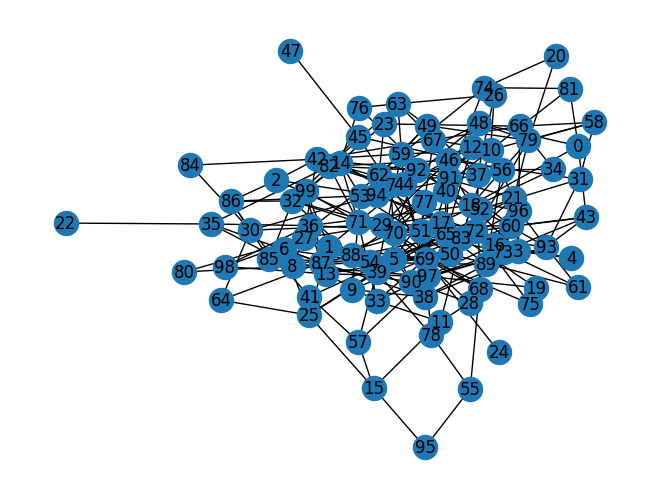

In [ ]:
nx.draw(G, pos=nx.spring_layout(G, seed=2023), with_labels=True)

In [ ]:
embedding_d0 = int(np.sqrt(G.number_of_nodes()))
embedding_d1 = embedding_d0 // 2

In [ ]:
learning_rate = 1e-4

In [ ]:
rng = jax.random.PRNGKey(2023)
rng, init_rng = jax.random.split(rng)
rng, embed_rng = jax.random.split(rng)
state = create_train_state(
    G.number_of_nodes(),
    embedding_d0,
    embedding_d1,
    init_rng,
    learning_rate,
    dropout_frac=0.01,
)

In [ ]:
node_embeddings = jax.random.uniform(embed_rng, [G.number_of_nodes(), embedding_d0])

In [ ]:
num_epochs = 1000

In [ ]:
rng, dropout_rng = jax.random.split(rng)

state, metrics = train_step(
        state=state,
        node_embeddings=node_embeddings,
        adj_matrix=A,
        q_matrix=Q,
        dropout_rng=dropout_rng,
    )
loss_ = metrics["energy"]
prev_loss = 0

In [ ]:
i = 1
count = 0
while (count < 100):
  # rng, dropout_rng = jax.random.split(rng)
  prev_loss = metrics["energy"]
  state, metrics = train_step(
    state=state,
    node_embeddings=node_embeddings,
    adj_matrix=A,
    q_matrix=Q,
    dropout_rng=dropout_rng,
  )
  loss_ = metrics["energy"]
  if (abs(loss_ - prev_loss) <= 0.001) | ((loss_ - prev_loss) > 0):
    count += 1
  else:
    count = 0
  i += 1
  if i % 1000 == 0:
    print("train epoch: %d, cost: %.2f" % (i, metrics["energy"]))


In [ ]:
# For fixed number of epochs used this code cell and comment the last one

# for epoch in trange(1, num_epochs + 1):
    # rng, dropout_rng = jax.random.split(rng)
#     state, metrics = train_step(
#         state=state,
#         node_embeddings=node_embeddings,
#         adj_matrix=A,
#         q_matrix=Q,
#         dropout_rng=dropout_rng,
#     )

#     if epoch % 25 == 0:
#         print("train epoch: %d, cost: %.2f" % (epoch, metrics["energy"]))

In [ ]:
# | export
def get_classification(apply_fn, params, node_embeddings, adj_matrix):
    pred_probs = apply_fn({"params": params}, node_embeddings, adj_matrix)
    classification = jnp.where(pred_probs >= 0.5, 1, 0)
    return np.ravel(classification)

In [ ]:
classification = get_classification(state.apply_fn, state.params, node_embeddings, A)

In [ ]:
set_1 = np.array([node for node, entry in enumerate(classification) if entry == 1])
set_2 = np.array([node for node, entry in enumerate(classification) if entry == 0])

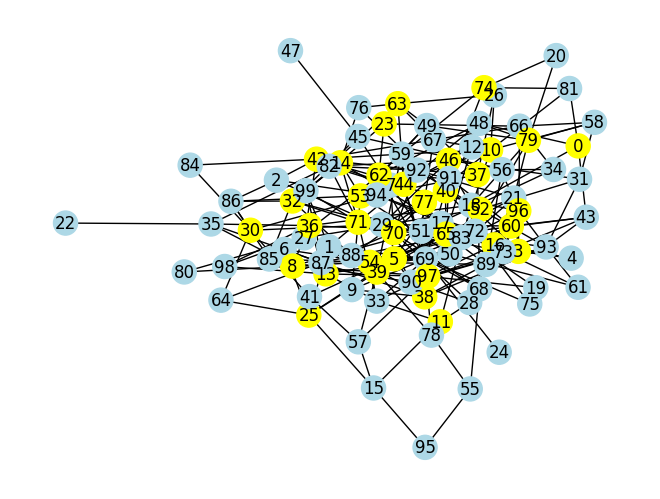

In [ ]:
nx.draw(
    G,
    pos=nx.spring_layout(G, seed=2023),
    node_color=["yellow" if c else "lightblue" for c in classification],
    with_labels=True,
)

In [ ]:
G_2_i = G.subgraph(set_2)

In [ ]:
new_s = []
for i,j in G_2_i.degree:
  if j != 0:
    new_s.append(i)

In [ ]:
G_2_i = G_2_i.subgraph(new_s)

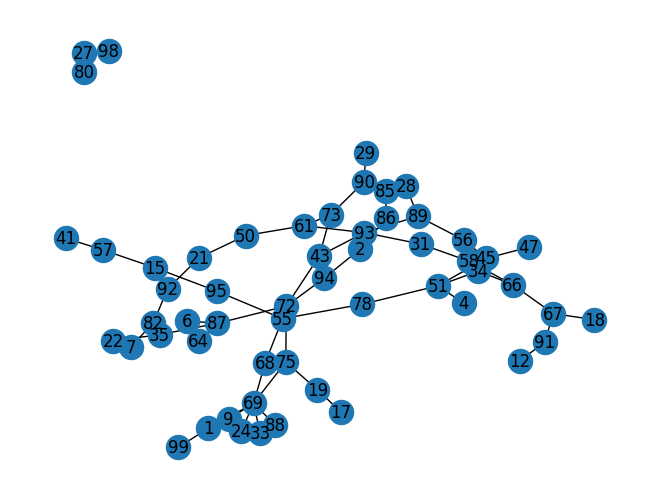

In [ ]:
# plt.clf()
# plt.figure(figsize=(12, 12))
# color_map = ['orange' if (best_bitstring[node]==-1) else 'blue' for node in H.nodes]
nx.draw(
    G_2_i,
    pos=nx.spring_layout(G_2_i, seed=2023),
    with_labels=True,
)
# plt.title('Graph Representation', size=15)
# plt.show()

In [ ]:
set_min_2 = min_weighted_vertex_cover(G_2_i, weight=None)

In [ ]:
for i in set_min_2:
  set_1 = np.append(set_1, [i])

In [ ]:
class_3 = []
for c in G_2_i.nodes:
  if c in set_min_2:
    class_3.append(1)
  else:
    class_3.append(0)

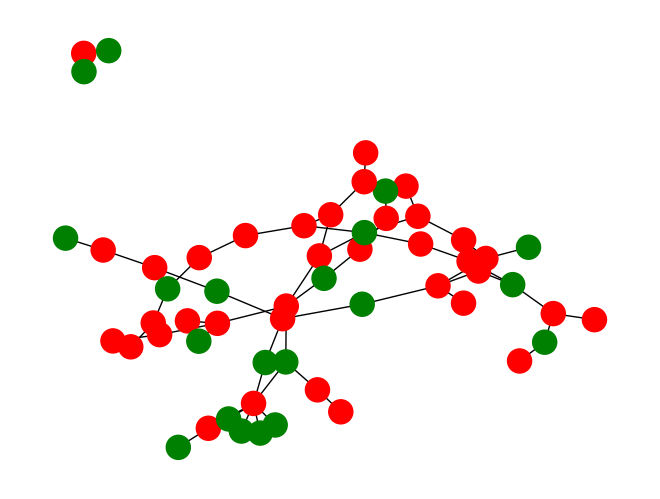

In [ ]:
import matplotlib.pyplot as plt
# plt.figure(figsize=(8, 6))
nx.draw(G_2_i, pos=nx.spring_layout(G_2_i, seed=2023), node_color=["red" if c else "green" for c in class_3])
# plt.title('Graph Representation', size=15)
# plt.show()

In [ ]:
class_final = []
for c in G.nodes:
  if c in set_1:
    class_final.append(1)
  else:
    class_final.append(0)

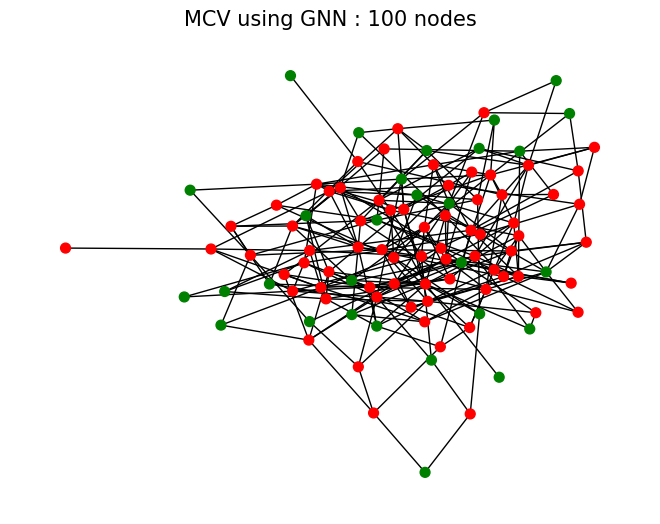

In [ ]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(8, 6))
nx.draw(G, pos=nx.spring_layout(G, seed=2023), node_color=["red" if c else "green" for c in class_final], with_labels=False, node_size = 50)
plt.title('MCV using GNN : 100 nodes', size=15)
plt.savefig('/content/MVC_GNN_100.png', dpi = 300)
# plt.show()

In [ ]:
from networkx.algorithms.approximation import min_weighted_vertex_cover

In [ ]:
set_min_1 = min_weighted_vertex_cover(G, weight=None)

In [ ]:
class_2 = []
for c in G.nodes:
  if c in set_min_1:
    class_2.append(1)
  else:
    class_2.append(0)

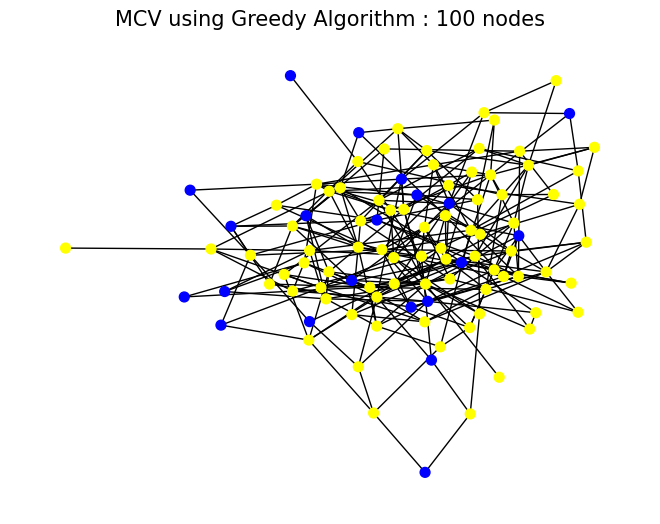

In [ ]:
nx.draw(
    G,
    pos=nx.spring_layout(G, seed=2023),
    node_color=["yellow" if c else "blue" for c in class_2],
    with_labels=False,
    node_size = 50
)
plt.title('MCV using Greedy Algorithm : 100 nodes', size=15)
plt.savefig('/content/MVC_GA_100.png', dpi = 300)

In [ ]:
print("Size of MVC set obtained by GNN : ", sum(class_final))
print("Size of MVC set obtained by Greedy Algorithm : ", sum(class_2))

Size of MVC set obtained by GNN :  71
Size of MVC set obtained by Greedy Algorithm :  79


# MCV for INP Files

In [ ]:
import wntr

In [ ]:
wn = wntr.network.WaterNetworkModel('/content/Richmond_skeleton.inp')

/usr/local/lib/python3.10/dist-packages/wntr/epanet/io.py:2082: UserWarning: Not all curves were used in "/content/Richmond_skeleton.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))


In [ ]:
def create_mvc_model(graph, penalty=2):
    N = graph.number_of_nodes()
    X = Array.create("X", shape=(N,), vartype="BINARY")

    hamiltonian = sum(X)
    for u, v, w in graph.edges:
        hamiltonian += penalty * (1 - X[int(u)])*(1 - X[int(v)])
    for u in graph.nodes:
        hamiltonian += X[int(u)]
    return hamiltonian.compile() 

In [ ]:

DG = wn.to_graph()
G = nx.convert_node_labels_to_integers(DG.to_undirected())
# uG = G.to_undirected()

In [ ]:
# Record node postitons for better visualization
node_positions = {node[0]: (node[1]['pos'][0], node[1]['pos'][1]) for node in G.nodes(data=True)}

In [ ]:
A = jnp.array(nx.to_numpy_array(G))

In [ ]:
Q = create_Q_matrix(G, is_max_cut=False)

{('X[44]', 'X[44]'): -2.0, ('X[25]', 'X[25]'): -2.0, ('X[42]', 'X[24]'): 2.0, ('X[29]', 'X[29]'): -2.0, ('X[6]', 'X[5]'): 2.0, ('X[39]', 'X[31]'): 2.0, ('X[38]', 'X[12]'): 2.0, ('X[10]', 'X[10]'): -2.0, ('X[1]', 'X[1]'): -2.0, ('X[3]', 'X[3]'): -2.0, ('X[8]', 'X[7]'): 2.0, ('X[43]', 'X[38]'): 2.0, ('X[45]', 'X[34]'): 2.0, ('X[9]', 'X[4]'): 2.0, ('X[18]', 'X[17]'): 2.0, ('X[21]', 'X[21]'): -2.0, ('X[19]', 'X[19]'): -4.0, ('X[41]', 'X[19]'): 2.0, ('X[4]', 'X[0]'): 2.0, ('X[8]', 'X[8]'): -4.0, ('X[15]', 'X[13]'): 2.0, ('X[36]', 'X[19]'): 2.0, ('X[37]', 'X[17]'): 2.0, ('X[15]', 'X[14]'): 2.0, ('X[30]', 'X[29]'): 2.0, ('X[37]', 'X[12]'): 2.0, ('X[5]', 'X[5]'): -4.0, ('X[3]', 'X[1]'): 2.0, ('X[12]', 'X[12]'): -4.0, ('X[20]', 'X[19]'): 2.0, ('X[31]', 'X[30]'): 2.0, ('X[2]', 'X[0]'): 2.0, ('X[8]', 'X[5]'): 2.0, ('X[12]', 'X[8]'): 2.0, ('X[32]', 'X[31]'): 2.0, ('X[33]', 'X[13]'): 2.0, ('X[32]', 'X[1]'): 2.0, ('X[39]', 'X[39]'): -2.0, ('X[6]', 'X[6]'): -2.0, ('X[10]', 'X[9]'): 2.0, ('X[30]', 'X[

In [ ]:
G.number_of_nodes()

48

In [ ]:
# dimension of hidden layers depends upon the size of input graph
embedding_d0 = int(np.sqrt(G.number_of_nodes())) 
embedding_d1 = embedding_d0 // 2

In [ ]:
learning_rate = 1e-2

In [ ]:
rng = jax.random.PRNGKey(2023)
rng, init_rng = jax.random.split(rng)
rng, embed_rng = jax.random.split(rng)
state = create_train_state(
    G.number_of_nodes(),
    embedding_d0,
    embedding_d1,
    init_rng,
    learning_rate,
    dropout_frac=0.01,
)

In [ ]:
node_embeddings = jax.random.uniform(embed_rng, [G.number_of_nodes(), embedding_d0])

In [ ]:
num_epochs = 1000

In [ ]:
rng, dropout_rng = jax.random.split(rng)

state, metrics = train_step(
        state=state,
        node_embeddings=node_embeddings,
        adj_matrix=A,
        q_matrix=Q,
        dropout_rng=dropout_rng,
    )
loss_ = metrics["energy"]
prev_loss = 0

In [ ]:
i = 1
count = 0
while (count < 100):
  # rng, dropout_rng = jax.random.split(rng)
  prev_loss = metrics["energy"]
  state, metrics = train_step(
    state=state,
    node_embeddings=node_embeddings,
    adj_matrix=A,
    q_matrix=Q,
    dropout_rng=dropout_rng,
  )
  loss_ = metrics["energy"]
  if (abs(loss_ - prev_loss) <= 0.01) | ((loss_ - prev_loss) > 0):
    count += 1
  else:
    count = 0
  i += 1
  if i % 1000 == 0:
    print("train epoch: %d, cost: %.2f" % (i, metrics["energy"]))

In [ ]:
# for epoch in trange(1, num_epochs + 1):
    # rng, dropout_rng = jax.random.split(rng)
#     state, metrics = train_step(
#         state=state,
#         node_embeddings=node_embeddings,
#         adj_matrix=A,
#         q_matrix=Q,
#         dropout_rng=dropout_rng,
#     )

#     if epoch % 25 == 0:
#         print("train epoch: %d, cost: %.2f" % (epoch, metrics["energy"]))

In [ ]:
# | export
def get_classification(apply_fn, params, node_embeddings, adj_matrix):
    pred_probs = apply_fn({"params": params}, node_embeddings, adj_matrix)
    classification = jnp.where(pred_probs >= 0.5, 1, 0)
    return np.ravel(classification)

In [ ]:
classification = get_classification(state.apply_fn, state.params, node_embeddings, A)

In [ ]:
set_1 = np.array([node for node, entry in enumerate(classification) if entry == 1])
set_2 = np.array([node for node, entry in enumerate(classification) if entry == 0])

In [ ]:
set_1.size

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
nx.draw(G, pos=node_positions, node_size=10, node_color=["red" if c else "green" for c in classification])
# plt.title('Graph Representation', size=15)
plt.show()

In [ ]:
from networkx.algorithms.approximation import min_weighted_vertex_cover

In [ ]:
set_min_1 = min_weighted_vertex_cover(G, weight=None)

In [ ]:
class_2 = []
for c in G.nodes:
  if c in set_min_1:
    class_2.append(1)
  else:
    class_2.append(0)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
nx.draw(G, pos=node_positions, node_size=40, node_color=["yellow" if c else "blue" for c in class_2])
plt.title('MVC using Greedy Algorithm : 48 Nodes', size=15)
# plt.savefig('/content/MVC_GA_48.png', dpi = 300)
plt.show()

In [ ]:
G_2_i = G.subgraph(set_2)

In [ ]:
new_s = []
for i,j in G_2_i.degree:
  if j != 0:
    new_s.append(i)

In [ ]:
G_2_i = G_2_i.subgraph(new_s)

In [ ]:
node_positions_2 = {node[0]: (node[1]['pos'][0], node[1]['pos'][1]) for node in G_2_i.nodes(data=True)}

In [ ]:
plt.clf()
# plt.figure(figsize=(12, 12))
# color_map = ['orange' if (best_bitstring[node]==-1) else 'blue' for node in H.nodes]
nx.draw(G_2_i, pos=node_positions_2, node_size=20)
plt.title('Graph Representation', size=10)
plt.show()

In [ ]:
set_min_2 = min_weighted_vertex_cover(G_2_i, weight=None)

In [ ]:
for i in set_min_2:
  set_1 = np.append(set_1, [i])

In [ ]:
class_3 = []
for c in G_2_i.nodes:
  if c in set_min_2:
    class_3.append(1)
  else:
    class_3.append(0)

In [ ]:
import matplotlib.pyplot as plt
# plt.figure(figsize=(8, 6))
nx.draw(G_2_i, pos=node_positions_2, node_size=10, node_color=["red" if c else "green" for c in class_3])
# plt.title('Graph Representation', size=15)
plt.show()

In [ ]:
class_final = []
for c in G.nodes:
  if c in set_1:
    class_final.append(1)
  else:
    class_final.append(0)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
nx.draw(G, pos=node_positions, node_size=40, node_color=["red" if c else "green" for c in class_final])
plt.title('MVC using GNN : 48 Nodes', size=15)
# plt.savefig('/content/MVC_GNN_48.png', dpi = 300)
plt.show()

In [ ]:
print("Size of MVC set obtained by GNN : ", sum(class_final))
print("Size of MVC set obtained by Greedy Algorithm : ", sum(class_2))

## PMU

In [ ]:
!pip install -q pandapower

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 45.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 8.2 MB/s eta 0:00:00


In [ ]:
import pandapower.networks as pn
net =  pn.case9241pegase()
import pandapower

In [ ]:
DG = pandapower.topology.create_nxgraph(net)
# DG = net.to_graph()
G = nx.convert_node_labels_to_integers(DG.to_undirected())
# uG = G.to_undirected()

In [ ]:
def create_mvc_model(graph, penalty=2):
    N = graph.number_of_nodes()
    X = Array.create("X", shape=(N,), vartype="BINARY")

    hamiltonian = sum(X)
    for u, v, w in graph.edges:
        hamiltonian += penalty * (1 - X[int(u)])*(1 - X[int(v)])
    for u in graph.nodes:
        hamiltonian += X[int(u)]
    return hamiltonian.compile() 

In [ ]:
A = jnp.array(nx.to_numpy_array(G))
Q = create_Q_matrix(G, is_max_cut=False)
# Q = makeSymmetric(Q)

In [ ]:
nx.draw(G, pos=nx.spring_layout(G, seed=1), with_labels=False, node_size = 10)

In [ ]:
G.number_of_nodes()

In [ ]:
embedding_d0 = int(np.cbrt(G.number_of_nodes()))
embedding_d1 = embedding_d0 // 2

In [ ]:
learning_rate = 1e-2

In [ ]:
rng = jax.random.PRNGKey(2023)
rng, init_rng = jax.random.split(rng)
rng, embed_rng = jax.random.split(rng)
state = create_train_state(
    G.number_of_nodes(),
    embedding_d0,
    embedding_d1,
    init_rng,
    learning_rate,
    dropout_frac=0.01,
)

In [ ]:
node_embeddings = jax.random.uniform(embed_rng, [G.number_of_nodes(), embedding_d0])

In [ ]:
num_epochs = 1000

In [ ]:
rng, dropout_rng = jax.random.split(rng)

state, metrics = train_step(
        state=state,
        node_embeddings=node_embeddings,
        adj_matrix=A,
        q_matrix=Q,
        dropout_rng=dropout_rng,
    )
loss_ = metrics["energy"]
prev_loss = 0

In [ ]:
i = 1
count = 0
while (count < 100):
  # rng, dropout_rng = jax.random.split(rng)
  prev_loss = metrics["energy"]
  state, metrics = train_step(
    state=state,
    node_embeddings=node_embeddings,
    adj_matrix=A,
    q_matrix=Q,
    dropout_rng=dropout_rng,
  )
  loss_ = metrics["energy"]
  if (abs(loss_ - prev_loss) <= 0.01) | ((loss_ - prev_loss) > 0):
    count += 1
  else:
    count = 0
  i += 1
  if i % 1000 == 0:
    print("train epoch: %d, cost: %.2f" % (i, metrics["energy"]))

In [ ]:
# for epoch in trange(1, num_epochs + 1):
    # rng, dropout_rng = jax.random.split(rng)
#     state, metrics = train_step(
#         state=state,
#         node_embeddings=node_embeddings,
#         adj_matrix=A,
#         q_matrix=Q,
#         dropout_rng=dropout_rng,
#     )

#     if epoch % 25 == 0:
#         print("train epoch: %d, cost: %.2f" % (epoch, metrics["energy"]))

In [ ]:
# | export
def get_classification(apply_fn, params, node_embeddings, adj_matrix):
    pred_probs = apply_fn({"params": params}, node_embeddings, adj_matrix)
    classification = jnp.where(pred_probs >= 0.5, 1, 0)
    return np.ravel(classification)

In [ ]:
classification = get_classification(state.apply_fn, state.params, node_embeddings, A)

In [ ]:
set_1 = np.array([node for node, entry in enumerate(classification) if entry == 1])
set_2 = np.array([node for node, entry in enumerate(classification) if entry == 0])

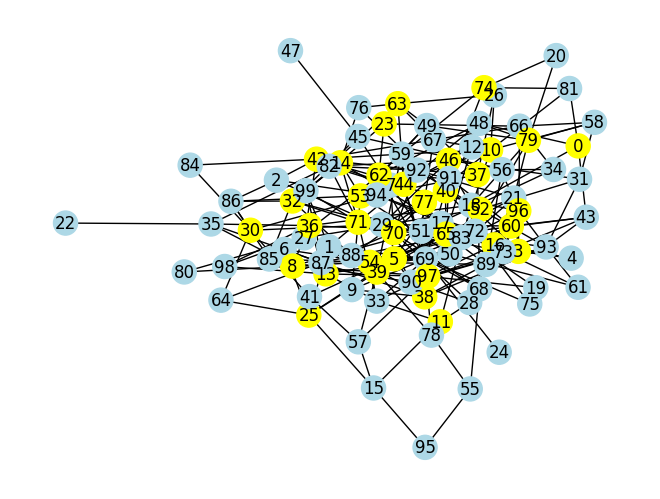

In [ ]:
nx.draw(
    G,
    pos=nx.spring_layout(G, seed=2023),
    node_color=["yellow" if c else "lightblue" for c in classification],
    with_labels=True,
)

In [ ]:
G_2_i = G.subgraph(set_2)

In [ ]:
new_s = []
for i,j in G_2_i.degree:
  if j != 0:
    new_s.append(i)

In [ ]:
G_2_i = G_2_i.subgraph(new_s)

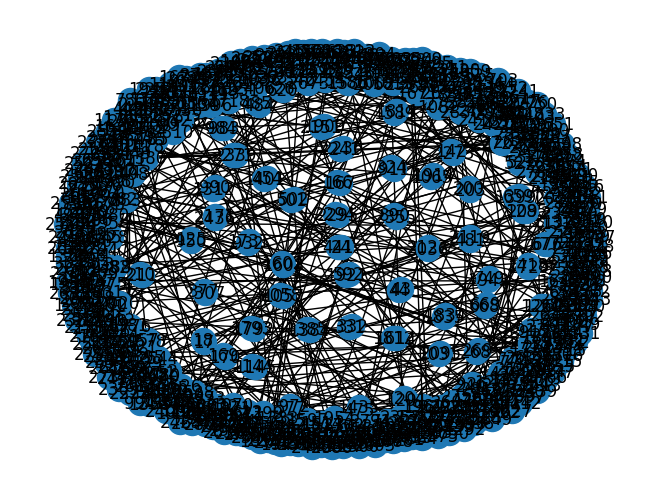

In [ ]:
# plt.clf()
# plt.figure(figsize=(12, 12))
# color_map = ['orange' if (best_bitstring[node]==-1) else 'blue' for node in H.nodes]
nx.draw(
    G_2_i,
    pos=nx.spring_layout(G_2_i, seed=3),
    with_labels=True,
)
# plt.title('Graph Representation', size=15)
# plt.show()

In [ ]:
set_min_2 = min_weighted_vertex_cover(G_2_i, weight=None)

In [ ]:
for i in set_min_2:
  set_1 = np.append(set_1, [i])

In [ ]:
class_3 = []
for c in G_2_i.nodes:
  if c in set_min_2:
    class_3.append(1)
  else:
    class_3.append(0)

In [ ]:
class_final = []
for c in G.nodes:
  if c in set_1:
    class_final.append(1)
  else:
    class_final.append(0)

In [ ]:
# import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
nx.draw(G, pos=nx.spring_layout(G, seed=2023), node_color=["red" if c else "green" for c in class_final], with_labels=False, node_size = 10)
plt.title('MCV using GNN : 9241 nodes', size=15)
plt.savefig('/content/MVC_GNN_9241.png', dpi = 300)
# plt.show()

In [ ]:
from networkx.algorithms.approximation import min_weighted_vertex_cover

In [ ]:
set_min_1 = min_weighted_vertex_cover(G, weight=None)

In [ ]:
class_2 = []
for c in G.nodes:
  if c in set_min_1:
    class_2.append(1)
  else:
    class_2.append(0)

In [ ]:
plt.figure(figsize=(8, 6))
nx.draw(
    G,
    pos=nx.spring_layout(G, seed=2023),
    node_color=["yellow" if c else "blue" for c in class_2],
    with_labels=False,
    node_size = 10
)
plt.title('MCV using Greedy Algorithm : 9241 nodes', size=15)
plt.savefig('/content/MVC_GA_9241.png', dpi = 300)

In [ ]:
print("Size of MVC set obtained by GNN : ", sum(class_final))
print("Size of MVC set obtained by Greedy Algorithm : ", sum(class_2))

Size of MVC set obtained by GNN :  4842
Size of MVC set obtained by Greedy Algorithm :  6199
